## 1. Import Libraries 

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import datetime as dt

from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer 
from sklearn.metrics import silhouette_score , silhouette_samples, calinski_harabasz_score
from sklearn.mixture import GaussianMixture
import plotly.express as px
import warnings
import joblib
warnings.filterwarnings('ignore')

# Set random seed untuk reprodusibilitas
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

## 2. Load Dataset

Dataset diambil dari GitHub repository sesuai ketentuan kompetisi.

In [44]:
# # Load dataset
# url = 'https://raw.githubusercontent.com/micelll/SPARC-2026/main/SPARC_dataset.csv'
# df = pd.read_csv(url)
# df.head()

In [45]:
df = pd.read_csv("../SPARC_dataset.csv")
df.head()

,Customer ID,Kelurahan,Kecamatan,Kode POS,Cash/Credit,Kode Dealer,Finance Company,Tenor,Gender,Tgl Lahir,...,range dp,wilayah,9 segment,kode motor,OTR,tahun rakit,DLR group,tgl cetak,tgl mohon,Kode Kota-Provinsi
0,CUST-159769,BARU ILIR,BALIKPAPAN BARAT,76131,2.0,12756.0,4,3,2,1992-03-03 0:00:00,...,2 - 3 JUTA,6471,AT LOW,HN,18685000.0,NAN,NAN,NaN,02-01-2019,6471-6400
1,CUST-164551,BARU TENGAH,BALIKPAPAN BARAT,76132,2.0,733.0,1,1,2,1991-04-27 0:00:00,...,3 JT UP,6471,AT LOW,HN,18685000.0,NAN,NAN,NaN,02012019,6471-6400
2,CUST-159733,BARU TENGAH,BALIKPAPAN BARAT,76132,1.0,733.0,N,N,2,1982-01-04 0:00:00,...,KURANG 1 JUTA,6471,AT MID,HR,20775000.0,NAN,NAN,NaN,02012019,6471-6400
3,CUST-164422,BARU TENGAH,BALIKPAPAN BARAT,76132,1.0,733.0,N,N,2,1997-06-26 0:00:00,...,KRG 1 JT,6471,AT MID,HR,20775000.0,NAN,NAN,NaN,02012019,6471-6400
4,CUST-155472,BARU ULU,BALIKPAPAN BARAT,76133,2.0,11160.0,1,2,1,1996-07-12 0:00:00,...,2 - 3 JT,6471,AT MID,HR,20775000.0,NAN,NAN,NaN,02-01-2019,6471-6400


a

In [46]:
df.head()

,Customer ID,Kelurahan,Kecamatan,Kode POS,Cash/Credit,Kode Dealer,Finance Company,Tenor,Gender,Tgl Lahir,...,range dp,wilayah,9 segment,kode motor,OTR,tahun rakit,DLR group,tgl cetak,tgl mohon,Kode Kota-Provinsi
0,CUST-159769,BARU ILIR,BALIKPAPAN BARAT,76131,2.0,12756.0,4,3,2,1992-03-03 0:00:00,...,2 - 3 JUTA,6471,AT LOW,HN,18685000.0,NAN,NAN,NaN,02-01-2019,6471-6400
1,CUST-164551,BARU TENGAH,BALIKPAPAN BARAT,76132,2.0,733.0,1,1,2,1991-04-27 0:00:00,...,3 JT UP,6471,AT LOW,HN,18685000.0,NAN,NAN,NaN,02012019,6471-6400
2,CUST-159733,BARU TENGAH,BALIKPAPAN BARAT,76132,1.0,733.0,N,N,2,1982-01-04 0:00:00,...,KURANG 1 JUTA,6471,AT MID,HR,20775000.0,NAN,NAN,NaN,02012019,6471-6400
3,CUST-164422,BARU TENGAH,BALIKPAPAN BARAT,76132,1.0,733.0,N,N,2,1997-06-26 0:00:00,...,KRG 1 JT,6471,AT MID,HR,20775000.0,NAN,NAN,NaN,02012019,6471-6400
4,CUST-155472,BARU ULU,BALIKPAPAN BARAT,76133,2.0,11160.0,1,2,1,1996-07-12 0:00:00,...,2 - 3 JT,6471,AT MID,HR,20775000.0,NAN,NAN,NaN,02-01-2019,6471-6400


In [47]:
# Informasi umum dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 317637 entries, 0 to 317636
Data columns (total 28 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Customer ID         317637 non-null  object 
 1   Kelurahan           317637 non-null  object 
 2   Kecamatan           317637 non-null  object 
 3   Kode POS            317637 non-null  object 
 4   Cash/Credit         317635 non-null  float64
 5   Kode Dealer         317635 non-null  float64
 6   Finance Company     317637 non-null  object 
 7   Tenor               317637 non-null  object 
 8   Gender              317637 non-null  object 
 9   Tgl Lahir           317635 non-null  object 
 10  Agama               317637 non-null  object 
 11  Pekerjaan           317637 non-null  object 
 12  umur                317635 non-null  float64
 13  dp aktual           317637 non-null  object 
 14  cicilan             317637 non-null  object 
 15  warna               317637 non-nul

data

In [48]:
missing_percentage = (df.isnull().sum() / len(df)) * 100
missing_percentage

Customer ID            0.000000
Kelurahan              0.000000
Kecamatan              0.000000
Kode POS               0.000000
Cash/Credit            0.000630
Kode Dealer            0.000630
Finance Company        0.000000
Tenor                  0.000000
Gender                 0.000000
Tgl Lahir              0.000630
Agama                  0.000000
Pekerjaan              0.000000
umur                   0.000630
dp aktual              0.000000
cicilan                0.000000
warna                  0.000000
dealer                 0.000000
type series            0.000000
range dp               0.000000
wilayah                0.000000
9 segment              0.000000
kode motor             0.000000
OTR                    0.001889
tahun rakit            0.000000
DLR group              0.000000
tgl cetak             95.857535
tgl mohon              0.000315
Kode Kota-Provinsi     0.000000
dtype: float64

In [49]:
# Drop kolom tgl cetak dan DLR group karena missing value terlalu tinggi
df = df.drop('tgl cetak', axis=1, errors='ignore')
df = df.drop('DLR group', axis=1, errors='ignore')
df.info()
    

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 317637 entries, 0 to 317636
Data columns (total 26 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Customer ID         317637 non-null  object 
 1   Kelurahan           317637 non-null  object 
 2   Kecamatan           317637 non-null  object 
 3   Kode POS            317637 non-null  object 
 4   Cash/Credit         317635 non-null  float64
 5   Kode Dealer         317635 non-null  float64
 6   Finance Company     317637 non-null  object 
 7   Tenor               317637 non-null  object 
 8   Gender              317637 non-null  object 
 9   Tgl Lahir           317635 non-null  object 
 10  Agama               317637 non-null  object 
 11  Pekerjaan           317637 non-null  object 
 12  umur                317635 non-null  float64
 13  dp aktual           317637 non-null  object 
 14  cicilan             317637 non-null  object 
 15  warna               317637 non-nul

### Cleaning DP Aktual dan Cicilan

Membersihkan format rupiah yang tidak konsisten: "Rp 0", "Rp 6000", "0", "6000"

In [50]:
# Tampilkan semua nilai unik tanpa truncation
np.set_printoptions(threshold=np.inf) 
unique_values = df['dp aktual'].unique()
print(f"Total nilai unik: {len(unique_values)}")
print(unique_values)

Total nilai unik: 6904
['RP 21.000.000' '87800000' 'RP 0' '0' '21000000' '50000000' '48000000'
 'RP 38.000.000' '47500000' 'RP 25.000.000' '98000000' '38000000'
 '25000000' '37000000' '9700000' '17800000' 'RP 58.500.000'
 'RP 22.000.000' '30000000' 'NAN' 'RP 31.500.000' '100000000'
 'RP 51.700.000' '65000000' '20000000' '26700000' 'RP 15.000.000'
 'RP 47.800.000' '13000000' 'RP 50.000.000' '13700000' '18000000'
 '23700000' '18+N108700000' 'RP 13.000.000' '40000000' 'RP 17.800.000'
 '149200000' 'RP 17.000.000' 'RP 20.000.000' '22100000' '17700000'
 '35000000' 'RP 175.082.400' 'RP 35.000.000' 'RP 9.700.000'
 'RP 10.800.000' 'RP 30.000.000' 'RP 27.800.000' '22800000'
 'RP 29.000.000' '60000000' '30300000' '51500000' 'RP 11.800.000'
 '17000000' 'RP 22.200.000' '15000000' '10800000' 'RP 57.000.000'
 '11800000' '8000000' 'RP 22.800.000' '47000000' 'RP 202.000.000'
 '32500000' '27800000' 'RP 43.800.000' '22500000' '62500000' '57250000'
 '52500000' '14000000' 'RP 120.000.000' '18600000' '16700

In [51]:
df['dp_aktual_raw'] = df['dp aktual']
df['cicilan_raw'] = df['cicilan']


In [52]:
import numpy as np
import pandas as pd

def clean_rupiah(series):
    s = (
        series
        .astype(str)
        .str.upper()
        .str.replace('RP', '', regex=False)
        .str.replace(r'[^\d]', '', regex=True)
        .replace('', np.nan)
    )
    s = pd.to_numeric(s, errors='coerce')
    s.loc[s <= 0] = np.nan
    return s

df['dp aktual'] = clean_rupiah(df['dp aktual'])
df['cicilan'] = clean_rupiah(df['cicilan'])

df[['dp aktual', 'cicilan']].describe()



,dp aktual,cicilan
count,1.811040e+05,1.811000e+05
mean,2.799040e+07,1.414032e+07
std,8.829117e+07,4.233914e+08
min,1.000000e+00,1.000000e+00
25%,4.000000e+06,1.750000e+06
50%,2.000000e+07,1.200000e+07
75%,3.650000e+07,1.500000e+07
max,3.000000e+10,8.575233e+10


In [53]:
mask_dp_changed = df['dp aktual'].isna() & df['dp_aktual_raw'].notna()
mask_cic_changed = df['cicilan'].isna() & df['cicilan_raw'].notna()

df.loc[mask_dp_changed, ['dp_aktual_raw']].value_counts().head(20)


dp_aktual_raw
0                94884
RP 0             40949
NAN                700
Name: count, dtype: int64

In [54]:
df.loc[mask_dp_changed, ['dp_aktual_raw']].sample(10)


,dp_aktual_raw
188524,0
125146,0
100944,0
59334,RP 0
36904,RP 0
124347,RP 0
35474,0
309821,0
238100,RP 0
256826,0


In [55]:
mask_cash_zero = (df['Cash/Credit'] == 1) & (
    df['cicilan'].isna() | (df['cicilan'] == 0)
)

mask_credit_zero = (df['Cash/Credit'] == 2) & (
    df['cicilan'].isna() | (df['cicilan'] == 0)
)

mask_cash_zero.sum(), mask_credit_zero.sum()


(np.int64(136530), np.int64(5))

In [56]:
mask_cash_zero = (df['Cash/Credit'] == 1) & (
    df['cicilan'].isna() | (df['cicilan'] == 0)
)

mask_credit_zero = (df['Cash/Credit'] == 2) & (
    df['cicilan'].isna() | (df['cicilan'] == 0)
)

mask_cash_zero.sum(), mask_credit_zero.sum()


(np.int64(136530), np.int64(5))

In [57]:
df.loc[mask_cash_zero, ['Cash/Credit','cicilan','dp_aktual_raw']].sample(10)


,Cash/Credit,cicilan,dp_aktual_raw
281785,1.0,NaN,0
267101,1.0,NaN,0
86497,1.0,NaN,0
269907,1.0,NaN,0
173471,1.0,NaN,0
115156,1.0,NaN,0
269786,1.0,NaN,0
133312,1.0,NaN,0
220038,1.0,NaN,0
93892,1.0,NaN,0


### Standardisasi Format Tanggal (tgl mohon)

Menggunakan regex untuk menangani format tanggal yang tidak konsisten:
- Format 1: `02-01-2019` (dengan separator)
- Format 2: `02012019` (tanpa separator)

In [58]:
import re

def standardize_date(date_str):
    """
    Standardisasi format tanggal menggunakan regex dengan validasi
    Input: '02-01-2019', '02012019', '2019-01-02', dll
    Output: format standar 'DD-MM-YYYY' atau NaN jika tidak valid
    """
    if pd.isna(date_str):
        return np.nan
    
    date_str = str(date_str).strip()
    
    # Jika string kosong, return NaN
    if date_str == '' or date_str.lower() == 'nan':
        return np.nan
    
    # PENTING: Strip timestamp jika ada (spasi dan setelahnya)
    # "1992-03-03 0:00:00" → "1992-03-03"
    date_str = re.sub(r'\s+.*$', '', date_str)
    
    def validate_date(dd, mm, yyyy):
        """Validasi apakah tanggal valid"""
        try:
            dd_int = int(dd)
            mm_int = int(mm)
            yyyy_int = int(yyyy)
            
            # Validasi range
            if dd_int < 1 or dd_int > 31:
                return False
            if mm_int < 1 or mm_int > 12:
                return False
            if yyyy_int < 1900 or yyyy_int > 2026:
                return False
            
            return True
        except:
            return False
    
    # Pattern 1: DDMMYYYY (HARUS 8 digit, tidak lebih tidak kurang) -> DD-MM-YYYY
    pattern1 = re.match(r'^(\d{2})(\d{2})(\d{4})$', date_str)
    if pattern1:
        dd, mm, yyyy = pattern1.groups()
        if validate_date(dd, mm, yyyy):
            return f"{dd}-{mm}-{yyyy}"
        else:
            return np.nan
    
    # Pattern 2: DD/MM/YYYY atau DD-MM-YYYY atau DD.MM.YYYY -> DD-MM-YYYY
    pattern2 = re.match(r'^(\d{1,2})[-/.](\d{1,2})[-/.](\d{4})$', date_str)
    if pattern2:
        dd, mm, yyyy = pattern2.groups()
        if validate_date(dd, mm, yyyy):
            return f"{dd.zfill(2)}-{mm.zfill(2)}-{yyyy}"
        else:
            return np.nan
    
    # Pattern 3: YYYY-MM-DD atau YYYY/MM/DD -> DD-MM-YYYY
    pattern3 = re.match(r'^(\d{4})[-/.](\d{1,2})[-/.](\d{1,2})$', date_str)
    if pattern3:
        yyyy, mm, dd = pattern3.groups()
        if validate_date(dd, mm, yyyy):
            return f"{dd.zfill(2)}-{mm.zfill(2)}-{yyyy}"
        else:
            return np.nan
    
    # Pattern 4: DD-MMM-YYYY (e.g., 02-Jan-2019)
    pattern4 = re.match(r'^(\d{1,2})[-/.]([A-Za-z]{3})[-/.](\d{4})$', date_str)
    if pattern4:
        dd, mmm, yyyy = pattern4.groups()
        month_map = {
            'jan': '01', 'feb': '02', 'mar': '03', 'apr': '04',
            'may': '05', 'jun': '06', 'jul': '07', 'aug': '08',
            'sep': '09', 'oct': '10', 'nov': '11', 'dec': '12'
        }
        mm = month_map.get(mmm.lower(), '01')
        if validate_date(dd, mm, yyyy):
            return f"{dd.zfill(2)}-{mm}-{yyyy}"
        else:
            return np.nan
    
    # Jika tidak match pattern apapun atau tidak valid, return NaN (bukan original)
    # Data anomali seperti "319977" akan jadi NaN
    return np.nan

# Standardisasi tgl mohon
before_missing = df['tgl mohon'].isna().sum()

# Terapkan standardisasi
df['tgl mohon'] = df['tgl mohon'].apply(standardize_date)

# Verifikasi sample hasil
print(df['tgl mohon'].dropna().head(20).tolist())

# Cek apakah ada format yang tidak terstandarisasi
non_standard = df['tgl mohon'].dropna()
non_standard = non_standard[~non_standard.str.match(r'^\d{2}-\d{2}-\d{4}$', na=False)]
if len(non_standard) > 0:
    print(f"\n⚠️  Ditemukan {len(non_standard):,} format yang tidak terstandarisasi:")
    print(non_standard.unique()[:10])
else:
    print("Semua format tgl mohon berhasil distandarisasi ke DD-MM-YYYY")

# Standardisasi Tgl Lahir 
print("\nStandardisasi Tgl Lahir")
df['Tgl Lahir'] = df['Tgl Lahir'].apply(standardize_date)
after_missing_lahir = df['Tgl Lahir'].isna().sum()
print(f"✓ Sample: {df['Tgl Lahir'].dropna().head(5).tolist()}")


['02-01-2019', '02-01-2019', '02-01-2019', '02-01-2019', '02-01-2019', '02-01-2019', '02-01-2019', '02-01-2019', '02-01-2019', '02-01-2019', '02-01-2019', '02-01-2019', '02-01-2019', '02-01-2019', '02-01-2019', '02-01-2019', '02-01-2019', '02-01-2019', '02-01-2019', '02-01-2019']
Semua format tgl mohon berhasil distandarisasi ke DD-MM-YYYY

Standardisasi Tgl Lahir
✓ Sample: ['03-03-1992', '27-04-1991', '04-01-1982', '26-06-1997', '12-07-1996']


### Mapping Nilai "N" (Others) Sebelum Konversi

Nilai "N" dalam beberapa kolom merepresentasikan kategori "Others/Lain-lain". Harus di-mapping ke kode numerik sebelum konversi agar tidak hilang sebagai NULL.

In [59]:
# # Mapping nilai "N" ke kode numerik untuk kolom kategorikal
# print("=" * 80)
# print("MAPPING NILAI 'N' (Others/Lain-lain)")
# print("=" * 80)

# # 1. TENOR: N → 0 (Others)
# if 'Tenor' in df.columns:
#     before = (df['Tenor'].astype(str).str.upper() == 'N').sum()
#     df['Tenor'] = df['Tenor'].astype(str).str.upper().replace('N', '0')
#     print(f"✓ Tenor: {before:,} nilai 'N' → '0' (Others)")

# # 2. GENDER: N → 3 (Lain-lain)
# if 'Gender' in df.columns:
#     before = (df['Gender'].astype(str).str.upper() == 'N').sum()
#     df['Gender'] = df['Gender'].astype(str).str.upper().replace('N', '3')
#     print(f"✓ Gender: {before:,} nilai 'N' → '3' (Lain-lain)")

# # 3. AGAMA: N → 8 (Lain-lain)
# if 'Agama' in df.columns:
#     before = (df['Agama'].astype(str).str.upper() == 'N').sum()
#     df['Agama'] = df['Agama'].astype(str).str.upper().replace('N', '8')
#     print(f"✓ Agama: {before:,} nilai 'N' → '8' (Lain-lain)")

# # 4. PEKERJAAN: N → 99 (Lain-lain)
# if 'Pekerjaan' in df.columns:
#     before = (df['Pekerjaan'].astype(str).str.upper() == 'N').sum()
#     df['Pekerjaan'] = df['Pekerjaan'].astype(str).str.upper().replace('N', '99')
#     print(f"✓ Pekerjaan: {before:,} nilai 'N' → '99' (Lain-lain)")

# # 5. FINANCE COMPANY: N → 99 (OTHER)
# if 'Finance Company' in df.columns:
#     before = (df['Finance Company'].astype(str).str.upper() == 'N').sum()
#     df['Finance Company'] = df['Finance Company'].astype(str).str.upper().replace('N', '99')
#     print(f"✓ Finance Company: {before:,} nilai 'N' → '99' (OTHER)")

# print("\n✓ Mapping selesai. Data siap untuk konversi tipe data.")

### Summary Cleaning Results

Ringkasan hasil pembersihan data sebelum konversi tipe data.

In [60]:
# print("=" * 80)
# print("SUMMARY: HASIL CLEANING DATA")
# print("=" * 80)

# print("\n1. FORMAT CURRENCY (DP Aktual, Cicilan, OTR):")
# print("   ✓ Format 'Rp X' berhasil dibersihkan")
# print("   ✓ Nilai numerik sudah konsisten")

# print("\n2. KOLOM TGL CETAK:")
# print("   ✓ Telah di-drop karena missing value >80%")

# print("\n3. FORMAT TANGGAL (tgl mohon, Tgl Lahir):")
# print("   ✓ Format tidak konsisten berhasil distandarisasi")
# print("   ✓ Semua tanggal dalam format DD-MM-YYYY")

# print("\n4. NILAI 'N' (Others):")
# print("   ✓ Tenor: N → 0")
# print("   ✓ Gender: N → 3")
# print("   ✓ Agama: N → 8")
# print("   ✓ Pekerjaan: N → 99")
# print("   ✓ Finance Company: N → 99")

# print("\n5. SHAPE DATA:")
# print(f"   Jumlah baris: {len(df):,}")
# print(f"   Jumlah kolom: {len(df.columns):,}")

# print("\n" + "=" * 80)
# print("DATA SIAP UNTUK KONVERSI TIPE DATA")
# # print("=" * 80)

## Konversi Tipe Data

Setelah cleaning, data siap dikonversi ke tipe data yang sesuai.

In [61]:
# String/Categorical columns
cols_str = [
    "Customer ID", "Kelurahan", "Kecamatan", "Kode POS", "Cash/Credit", "Kode Dealer", "Finance Company", "Tenor",
    "Gender", "Agama", "Pekerjaan", "warna", "dealer", "type series", 
    "range dp", "wilayah", "9 segment", "kode motor", 
    "Kode Kota-Provinsi"
]

# Numeric columns
cols_num = [
    "umur", "dp aktual", "cicilan", "OTR", "tahun rakit"
]

# Date columns
cols_date = [
    "Tgl Lahir", "tgl mohon"  # tgl cetak sudah di-drop
]

# Apply transformations dengan error handling
df[cols_str] = df[cols_str].astype("string")
df[cols_num] = df[cols_num].apply(pd.to_numeric, errors="coerce")
# Konversi datetime 
df[cols_date] = df[cols_date].apply(pd.to_datetime, format='%d-%m-%Y', errors="coerce")


In [62]:

missing_percentage = (df.isnull().sum() / len(df)) * 100
missing_percentage

Customer ID            0.000000
Kelurahan              0.000000
Kecamatan              0.000000
Kode POS               0.000000
Cash/Credit            0.000630
Kode Dealer            0.000630
Finance Company        0.000000
Tenor                  0.000000
Gender                 0.000000
Tgl Lahir              0.008815
Agama                  0.000000
Pekerjaan              0.000000
umur                   0.000630
dp aktual             42.983972
cicilan               42.985232
warna                  0.000000
dealer                 0.000000
type series            0.000000
range dp               0.000000
wilayah                0.000000
9 segment              0.000000
kode motor             0.000000
OTR                    0.001889
tahun rakit            3.136599
tgl mohon             38.064835
Kode Kota-Provinsi     0.000000
dp_aktual_raw          0.000000
cicilan_raw            0.000000
dtype: float64

In [63]:
#drop missin value
critical_cols = ['tgl mohon', 'tahun rakit', 'OTR']   # tambah kalau perlu
df = df.dropna(subset=critical_cols)
df.isna().sum()

Customer ID               0
Kelurahan                 0
Kecamatan                 0
Kode POS                  0
Cash/Credit               0
Kode Dealer               0
Finance Company           0
Tenor                     0
Gender                    0
Tgl Lahir                12
Agama                     0
Pekerjaan                 0
umur                      0
dp aktual             81128
cicilan               81132
warna                     0
dealer                    0
type series               0
range dp                  0
wilayah                   0
9 segment                 0
kode motor                0
OTR                       0
tahun rakit               0
tgl mohon                 0
Kode Kota-Provinsi        0
dp_aktual_raw             0
cicilan_raw               0
dtype: int64

In [64]:
df = df.drop_duplicates()
df.duplicated().sum()

np.int64(0)

In [65]:
#cek jumlah baris dat
print(f"Jumlah baris data setelah cleaning: {len(df):,}")

Jumlah baris data setelah cleaning: 186,762


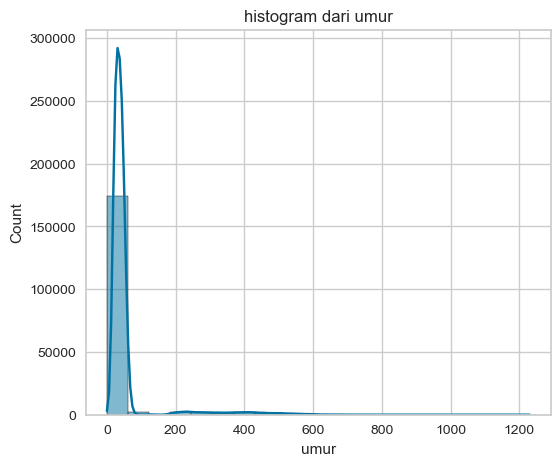

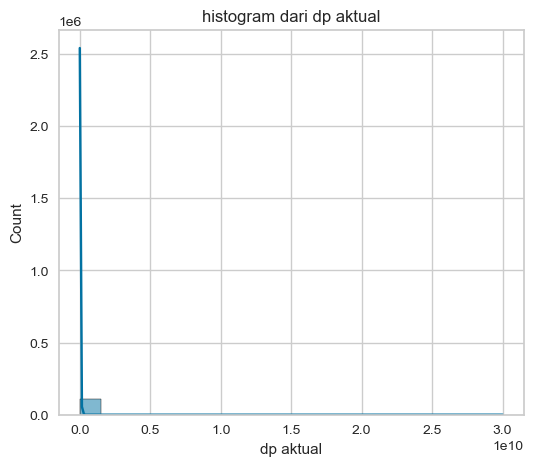

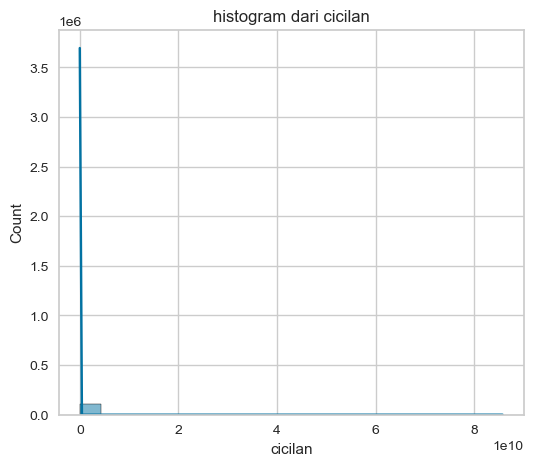

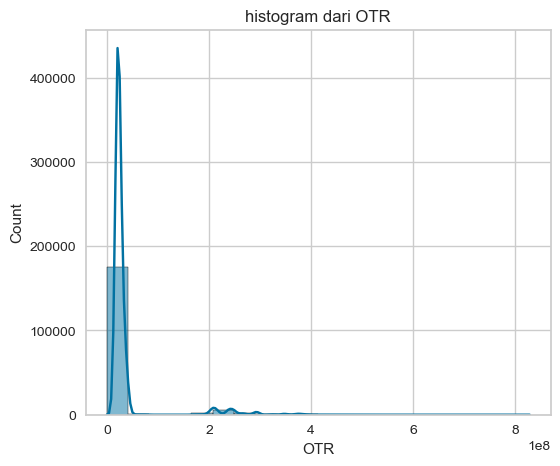

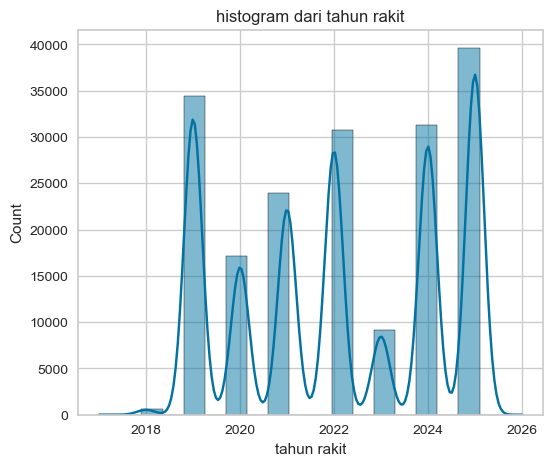

In [66]:
numerical_cols = df.select_dtypes(include=np.number).columns

for col in numerical_cols:
  plt.figure(figsize=(6,5))
  sns.histplot(df[col],kde=True,bins=20)
  plt.title(f'histogram dari {col}')
  plt.show()

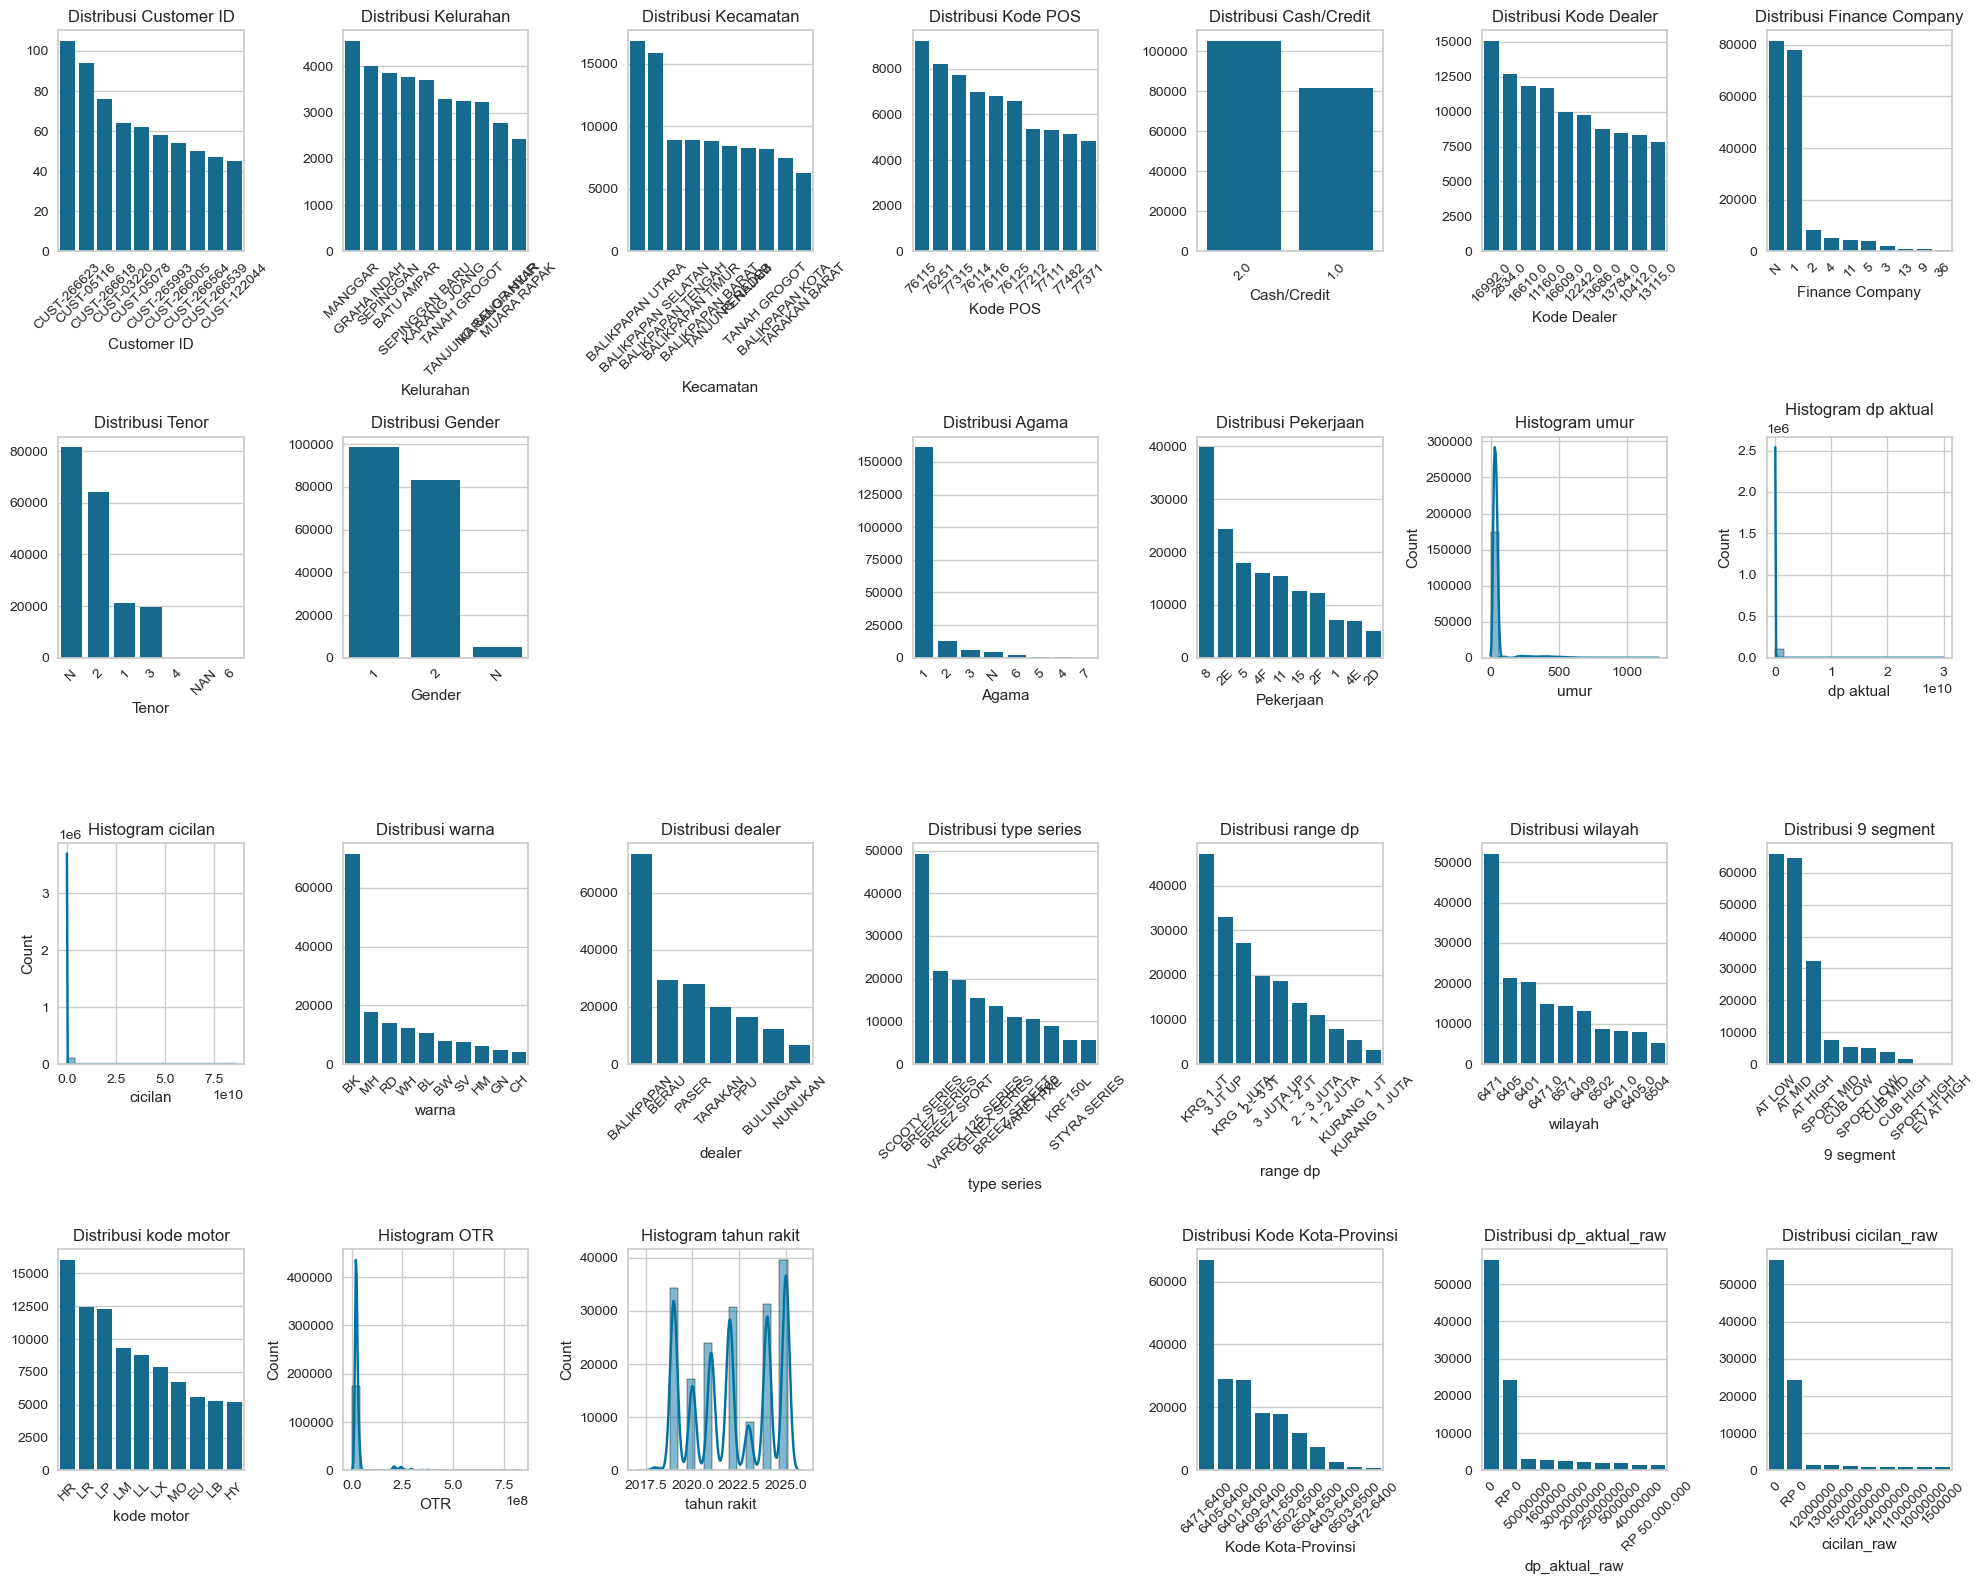

In [67]:
# Visualisasi yang lebih informatif (Opsional Advanced 1)
numerical_cols = df.select_dtypes(include=['int64','float64']).columns
categorical_cols= df.select_dtypes(include=['object','category','string']).columns

all_cols = df.columns
n = len(all_cols)

ncols = 7  # Lebih banyak kolom agar muat di layar
nrows = int(np.ceil(n / ncols))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 4*nrows))  # Lebih rendah per row
axes = axes.flatten()

for i, col in enumerate(all_cols):
    ax = axes[i]
    if col in numerical_cols:
        sns.histplot(df[col], kde=True, bins=20, ax=ax)
        ax.set_title(f"Histogram {col}")
    elif col in categorical_cols:
        vc = df[col].value_counts().nlargest(10)
        sns.barplot(x=vc.index, y=vc.values, ax=ax)
        ax.set_title(f"Distribusi {col}")
        ax.tick_params(axis='x', rotation=45)
    else:
        ax.set_visible(False)
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### (DRAFT) fitur yang dipakai: 
Tenor

tahun rakit (atau usia unit),

dp aktual, 

cicilan, 

Cash/Credit, 

Harga OTR, 

Pekerjaan  

#### Cek per fitur

In [68]:
df_labeling = df.copy()
df_labeling = df_labeling[['Tenor', 'tahun rakit', 'dp aktual', 'cicilan', 'Cash/Credit' ,'OTR', 'Pekerjaan']]
df_labeling.head()

,Tenor,tahun rakit,dp aktual,cicilan,Cash/Credit,OTR,Pekerjaan
9843,1,2019.0,250000000.0,12000000.0,2.0,34750000.0,7
9844,2,2019.0,42000000.0,18320000.0,2.0,31400000.0,2D
9845,2,2019.0,25000000.0,15100000.0,2.0,21025000.0,5
9846,2,2019.0,25000000.0,15000000.0,2.0,21025000.0,8
9847,1,2019.0,145000000.0,33500000.0,2.0,31400000.0,8


In [69]:
df_labeling.info()

<class 'pandas.core.frame.DataFrame'>
Index: 186762 entries, 9843 to 317635
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Tenor        186762 non-null  string 
 1   tahun rakit  186762 non-null  float64
 2   dp aktual    105641 non-null  float64
 3   cicilan      105637 non-null  float64
 4   Cash/Credit  186762 non-null  string 
 5   OTR          186762 non-null  float64
 6   Pekerjaan    186762 non-null  string 
dtypes: float64(4), string(3)
memory usage: 11.4 MB


##### Tenor

In [70]:
#cek jumlah data tiap tenor
print(df_labeling['Tenor'].value_counts())

Tenor
N      81484
2      64290
1      21377
3      19511
4         88
NAN       10
6          2
Name: count, dtype: Int64


##### tahun rakit

In [71]:
print(df_labeling['tahun rakit'].value_counts())

tahun rakit
2025.0    39601
2019.0    34414
2024.0    31257
2022.0    30705
2021.0    23918
2020.0    17177
2023.0     9111
2018.0      569
2017.0        9
2026.0        1
Name: count, dtype: int64


##### dp aktual

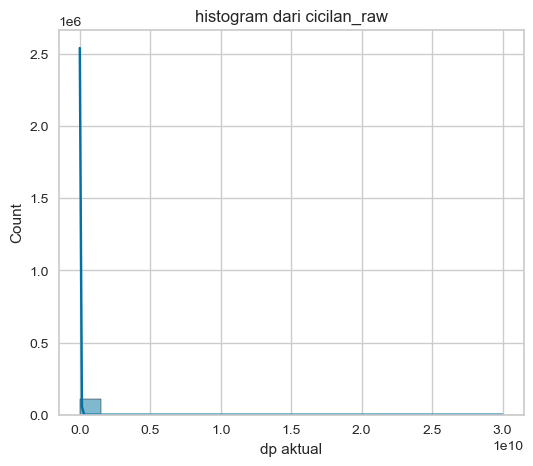

In [72]:
#plot dp aktual

plt.figure(figsize=(6,5))
sns.histplot(df['dp aktual'],kde=True,bins=20)
plt.title(f'histogram dari {col}')
plt.show()

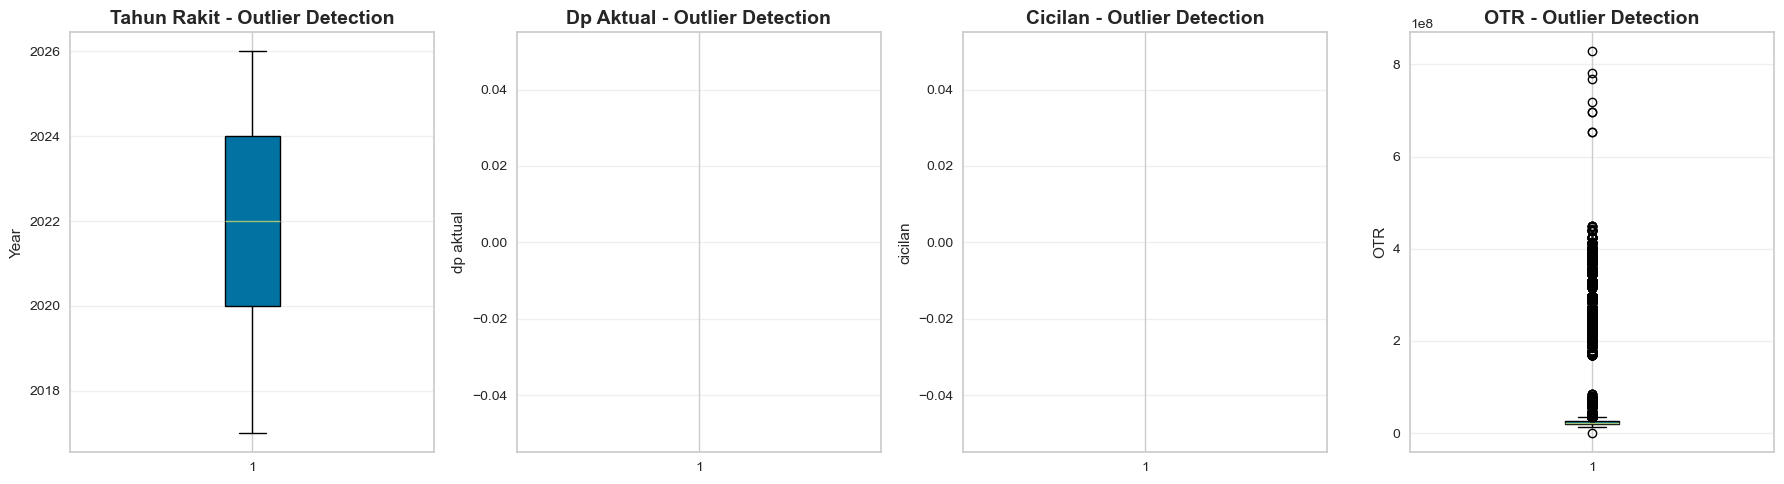

In [73]:
#tes doang
# Visualisasi outlier dengan boxplot
fig, axes = plt.subplots(1, 4, figsize=(18, 5))

# Boxplot untuk tahun rakit
axes[0].boxplot(df_labeling['tahun rakit'], vert=True, patch_artist=True)
axes[0].set_title('Tahun Rakit - Outlier Detection', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Year')
axes[0].grid(axis='y', alpha=0.3)

# Boxplot untuk dp aktual
axes[1].boxplot(df_labeling['dp aktual'], vert=True, patch_artist=True)
axes[1].set_title('Dp Aktual - Outlier Detection', fontsize=14, fontweight='bold')
axes[1].set_ylabel('dp aktual')
axes[1].grid(axis='y', alpha=0.3)

# Boxplot untuk cicilan
axes[2].boxplot(df_labeling['cicilan'], vert=True, patch_artist=True)
axes[2].set_title('Cicilan - Outlier Detection', fontsize=14, fontweight='bold')
axes[2].set_ylabel('cicilan')
axes[2].grid(axis='y', alpha=0.3)

# Boxplot untuk OTR
axes[3].boxplot(df_labeling['OTR'], vert=True, patch_artist=True)
axes[3].set_title('OTR - Outlier Detection', fontsize=14, fontweight='bold')
axes[3].set_ylabel('OTR')
axes[3].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

In [74]:
#tes doang
numerical_cols = df_labeling.select_dtypes(include=['int64','float64']).columns
Q1 = df_labeling[numerical_cols].quantile(0.25)
Q3 = df_labeling[numerical_cols].quantile(0.75)
IQR = Q3 - Q1

# Tentukan batas bawah dan atas
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR


# Pindahkan outlier ke batas (capping)
for col in numerical_cols:
    df_labeling[col] = np.where(df_labeling[col] < lower_bound[col], 
                                lower_bound[col], 
                                df_labeling[col])
    df_labeling[col] = np.where(df_labeling[col] > upper_bound[col], 
                                upper_bound[col], 
                                df_labeling[col])
#jumlah data yang dicapping
    print(f'Jumlah data yang dicapping pada kolom {col}: {((df_labeling[col] == lower_bound[col]) | (df_labeling[col] == upper_bound[col])).sum()}')

Jumlah data yang dicapping pada kolom tahun rakit: 0
Jumlah data yang dicapping pada kolom dp aktual: 6161
Jumlah data yang dicapping pada kolom cicilan: 612
Jumlah data yang dicapping pada kolom OTR: 20832


In [75]:
#tes doang
df_labeling.shape

(186762, 7)

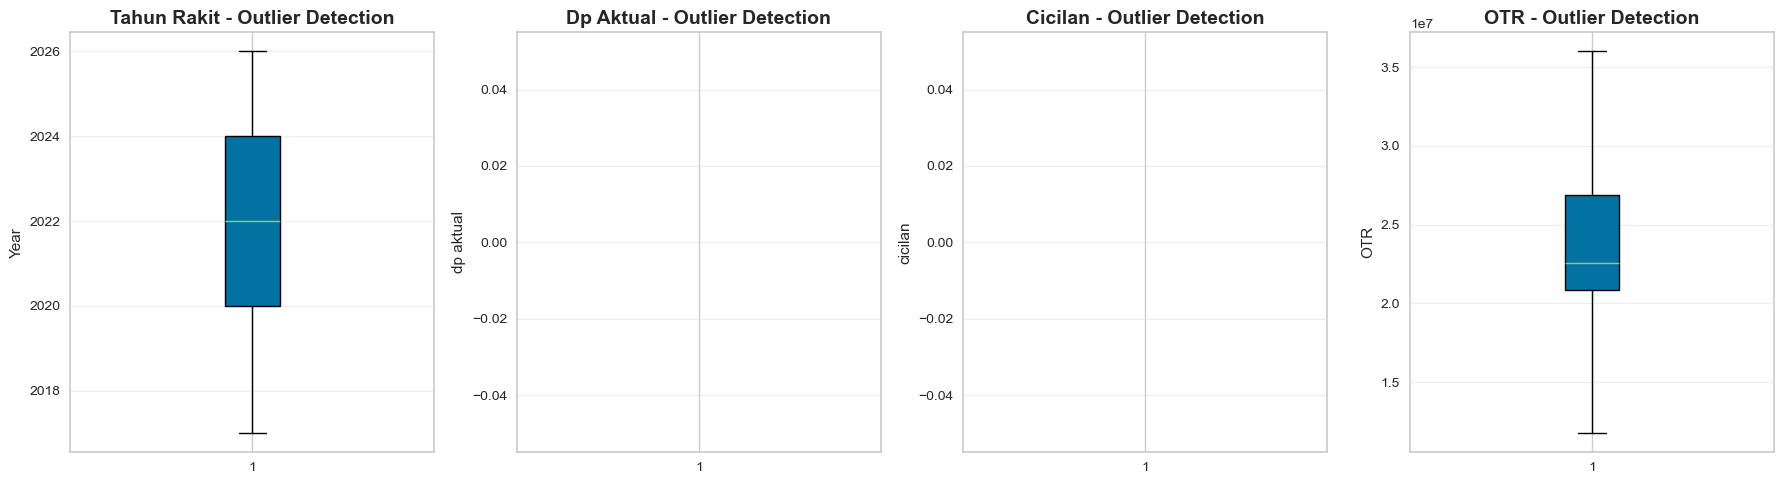

In [76]:
#tes doang
# Visualisasi outlier dengan boxplot
fig, axes = plt.subplots(1, 4, figsize=(18, 5))

# Boxplot untuk tahun rakit
axes[0].boxplot(df_labeling['tahun rakit'], vert=True, patch_artist=True)
axes[0].set_title('Tahun Rakit - Outlier Detection', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Year')
axes[0].grid(axis='y', alpha=0.3)

# Boxplot untuk dp aktual
axes[1].boxplot(df_labeling['dp aktual'], vert=True, patch_artist=True)
axes[1].set_title('Dp Aktual - Outlier Detection', fontsize=14, fontweight='bold')
axes[1].set_ylabel('dp aktual')
axes[1].grid(axis='y', alpha=0.3)

# Boxplot untuk cicilan
axes[2].boxplot(df_labeling['cicilan'], vert=True, patch_artist=True)
axes[2].set_title('Cicilan - Outlier Detection', fontsize=14, fontweight='bold')
axes[2].set_ylabel('cicilan')
axes[2].grid(axis='y', alpha=0.3)

# Boxplot untuk OTR
axes[3].boxplot(df_labeling['OTR'], vert=True, patch_artist=True)
axes[3].set_title('OTR - Outlier Detection', fontsize=14, fontweight='bold')
axes[3].set_ylabel('OTR')
axes[3].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

dp aktual anomali 

In [ ]:
# # Standardisasi kategori
# df['range dp'] = df['range dp'].str.upper().str.strip().replace({
#     '2 - 3 JT': '2-3JT',
#     '2 - 3 JUTA': '2-3JT',
#     '3 JUTA UP': '>3JT',
#     '3 JT UP': '>3JT',
#     'KURANG 1 JUTA': '<1JT',
#     'KRG 1 JUTA': '<1JT',
#     'KRG 1 JT': '<1JT',
#     '1 - 2 JT': '1-2JT',
#     '1 - 2 JUTA': '1-2JT',
#     'KURANG 1 JT': '<1JT'
# })
# #drop baris yang memiliki nilai range dp yang nan
# df = df.dropna(subset=['range dp'])

# print(f"Range DP unique: {df['range dp'].unique()}")

In [ ]:
# #standardisasi kategori lainnya
# df['Agama'] = df['Agama'].astype(str).str.upper().str.strip()
# df['Pekerjaan'] = df['Pekerjaan'].astype(str).str.upper().str.strip()
# df['Gender'] = df['Gender'].astype(str).str.upper().str.strip()
# df['warna'] = df['warna'].str.upper().str.strip()

In [ ]:
# df['tgl mohon'] = pd.to_datetime(df['tgl mohon'], errors='coerce', dayfirst=True)
# df['tgl cetak'] = pd.to_datetime(df['tgl cetak'], errors='coerce', dayfirst=True)
# df['Tgl Lahir'] = pd.to_datetime(df['Tgl Lahir'], errors='coerce', dayfirst=True)

# print(f"tgl mohon: {df['tgl mohon'].dtype}")
# print(f"tgl cetak: {df['tgl cetak'].dtype}")
# print(f"Tgl Lahir: {df['Tgl Lahir'].dtype}")
# print(df['tgl mohon'].head())
# print(df['tgl cetak'].head())
# print(df['Tgl Lahir'].head())


### Labeling

Note  (Opsional) Siapkan untuk model yang tidak bisa NaN

In [ ]:

df['is_cash'] = (df['cash_credit'] == 1).astype(int)
df['cicilan_missing'] = df['cicilan'].isna().astype(int)
df['cicilan_filled'] = df['cicilan'].fillna(-1)